In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import cProfile
import random
from math import ceil
import time

In [2]:
class Traveler:
    
    def __init__(self, cityCount, size, populationCount, crossProb=0.99, mutProb=0.05, 
                 selection='rank', randomState=None, cities=None, elitismRate=0.02):
        
        assert cityCount>1, 'Invalid cityCount value'
        assert size>0, 'Invalid size value'
        assert populationCount>0, 'Invalid populationCount value'
        assert crossProb>=0 and crossProb<=1, 'Invalid crossProb value'
        assert mutProb>=0 and mutProb<=1, 'Invalid mutProb value'
        assert selection == 'rank' or selection == 'roulette', 'Invalid selection value'
        assert elitismRate>=0, 'Invalid elitismRate value'
        
        self.cityCount = cityCount
        self.size = size
        self.populationCount = populationCount
        self.crossProb = crossProb
        self.mutProb = mutProb
        self.select = selection
        if selection == 'rank':
            self.select = self.rankSelection
        else:
            self.select = self.rouletteSelection
        
        np.random.seed(randomState)
        if cities is None:
            cities = size*np.random.rand(cityCount, 2)
        self.cities = cities
        self.distMatrix = sp.spatial.distance.cdist(self.cities, self.cities)
   
        self.left = ceil(self.populationCount * elitismRate)
        self.parentPerm = list(range(self.populationCount))
        self.cityPerm = list(range(self.cityCount))
        
        self.minLoss = []
        self.medianLoss = []
        self.maxLoss = []
        
    def countLoss(self, solution):
        return self.distMatrix[solution[:-1], solution[1:]].sum() + self.distMatrix[solution[0], solution[-1]]
        
    def fit(self, maxIter=300):
        assert maxIter>=0, 'Invalid maxIter value'
        
        # wylosuj populację początkową
        population = np.array([np.random.permutation(self.cityCount) for _ in range(self.populationCount)])
        loss = self.checkPopulation(population)
        
        for _ in range(maxIter):
           
            weights = self.select(loss)
            
            offspring = np.empty((0, self.cityCount), dtype='int')
            
            # wygeneruj nowych osobników 
            for _ in range(ceil((self.populationCount - self.left)/2)):
                
                # selekcja
                cand1, cand2 = population[random.choices(self.parentPerm, k=2, weights=weights)]
                
                # krzyżowanie
                if np.random.rand() < self.crossProb:                  
                    cand1, cand2 = self.crossover(cand1, cand2)
                    
                # mutacja
                if np.random.rand() < self.mutProb:
                    cand1 = self.mutate(cand1)
                if np.random.rand() < self.mutProb:
                    cand2 = self.mutate(cand2)
                
                offspring = np.vstack([offspring, cand1])
                offspring = np.vstack([offspring, cand2])
            
            if len(offspring) == self.populationCount - self.left:
                population = np.vstack([self.bestNPopulations, offspring])
            else:
                population = np.vstack([self.bestNPopulations, offspring[1:]])
            
            loss = self.checkPopulation(population)

        return self
        
    def checkPopulation(self, population):
        loss = np.array([self.countLoss(p) for p in population])
        self.minLoss.append(loss.min())
        self.maxLoss.append(loss.max())
        self.medianLoss.append(np.median(loss))
        self.bestNPopulations = population[loss.argsort()][:self.left]
        return loss
    
    def rankSelection(self, loss):
        weights = loss.argsort() / (len(loss) - 1)
        weights = 1 - weights
        return weights
    
    def rouletteSelection(self, loss):       
        weights = loss / loss.sum() 
        wMax = weights.max()
        wMin = weights.min()
        
        if wMax != wMin:
            weights = (weights - wMin) / (wMax - wMin)
            weights = 1 - weights
        else:
            weights = [1] * len(loss)
        
        return weights
    
    def crossover(self, cand1, cand2):
        split1, split2 = sorted(random.choices(self.cityPerm, k=2))
                    
        sliceToInsert1 = cand1[split1:split2]
        sliceToInsert2 = cand2[split1:split2]
                    
        cand1 = cand1[~np.isin(cand1, sliceToInsert2)] 
        cand2 = cand2[~np.isin(cand2, sliceToInsert1)] 
                    
        cand1 = np.insert(cand1, split1, sliceToInsert2)  
        cand2 = np.insert(cand2, split1, sliceToInsert1) 
        
        return cand1, cand2
    
    def mutate(self, cand):
        ix1, ix2 = random.choices(self.cityPerm, k=2) 
        cand[ix1], cand[ix2] = cand[ix2], cand[ix1]
        return cand
    
    def displayCities(self, ax=None, title=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        cities = self.cities.transpose()
        ax.scatter(cities[0], cities[1], color='red')
        ax.axis('square')
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        #ax.grid()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        if title is None:
            ax.set_title('Rozkład {} miast'.format(self.cityCount))
        else:
            ax.set_title(title)
        return self
    
    def displaySolution(self, ax=None, title=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        self.displayCities(ax, title)
        bestPopulation = self.bestNPopulations[0]
        bestPopulation = np.append(bestPopulation, bestPopulation[0])
        points = self.cities.take(bestPopulation, axis=0).transpose()
        ax.plot(points[0], points[1], 'tab:blue')
        return self
    
    def displayLoss(self, ax=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ax.plot(self.minLoss, 'g')
        ax.plot(self.medianLoss, 'b')
        ax.plot(self.maxLoss, 'r')
        ax.set_xlim(0, None)
        ax.grid()
        ax.set_xlabel('Numer pokolenia')
        ax.set_ylabel('Długość trasy')
        ax.set_title('Zmiany funkcji celu w kolejnych pokoleniach')
        return self

# Testowane rozkłady

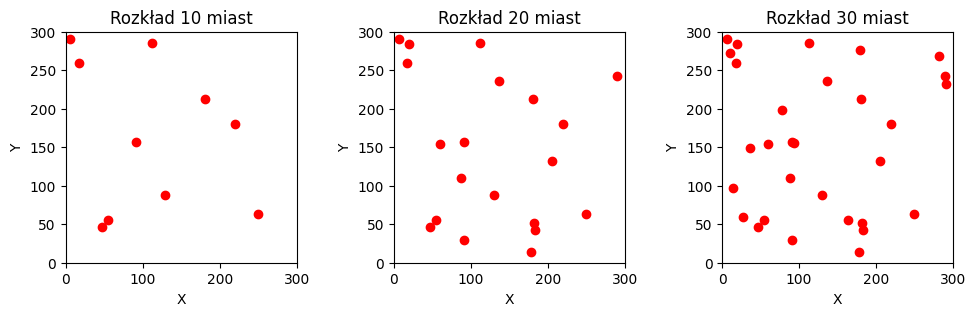

In [3]:
t10 = Traveler(cityCount=10, size=300, populationCount=16, randomState=42)
t20 = Traveler(cityCount=20, size=300, populationCount=16, randomState=42)
t30 = Traveler(cityCount=30, size=300, populationCount=16, randomState=42)

fig, axes = plt.subplots(1, 3, figsize=(12,3))
t10.displayCities(axes[0])
t20.displayCities(axes[1])
t30.displayCities(axes[2])

fig.savefig('01_citiesDistribution.png')

# Niestabilność rozwiązań

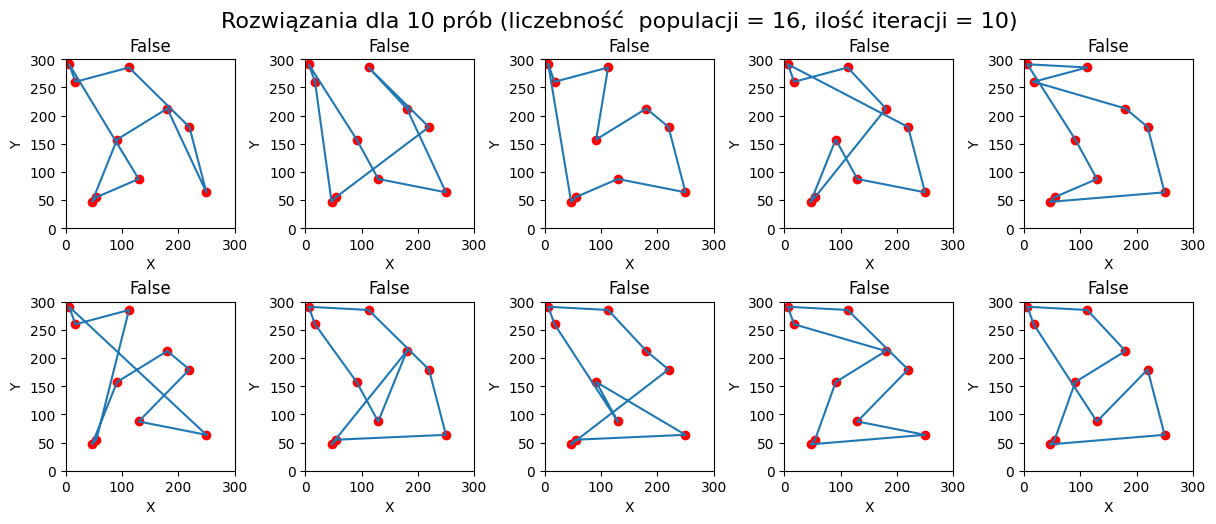

In [4]:
t10 = Traveler(cityCount=10, size=300, populationCount=16, randomState=42)

fig, axes = plt.subplots(2, 5, figsize=(12,5))
fig.tight_layout(w_pad=2)
fig.suptitle('Rozwiązania dla 10 prób (liczebność  populacji = 16, ilość iteracji = 10)', fontsize=16, y=1.03)
for i in range(2):
    for j in range(5):
        t10.fit(10).displaySolution(axes[i][j], title=False)

fig.savefig('02_exampleSolution_16_10.png')

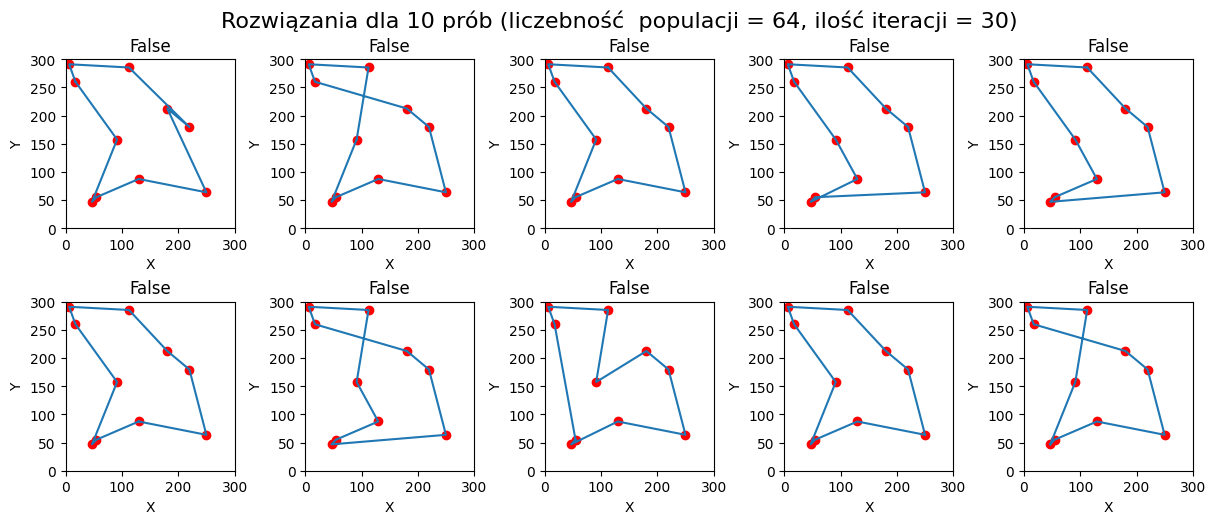

In [5]:
t10 = Traveler(cityCount=10, size=300, populationCount=64, randomState=42)

fig, axes = plt.subplots(2, 5, figsize=(12,5))
fig.tight_layout(w_pad=2)
fig.suptitle('Rozwiązania dla 10 prób (liczebność  populacji = 64, ilość iteracji = 30)', fontsize=16, y=1.03)
for i in range(2):
    for j in range(5):
        t10.fit(30).displaySolution(axes[i][j], title=False)
    
fig.savefig('03_exampleSolution_64_30.png')

# Wpływ liczebności populacji i ilości iteracji - metoda rankingowa

## Liczebność populacji

In [6]:
t10 = Traveler(cityCount=10, size=300, populationCount=10, randomState=42, selection='rank')
lossRun10cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun10cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=20, randomState=42, selection='rank')
lossRun20cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun20cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=30, randomState=42, selection='rank')
lossRun30cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun30cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=40, randomState=42, selection='rank')
lossRun40cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun40cand = %timeit -o t10.fit(25)

lossRunsCandRank = pd.DataFrame({"10" : lossRun10cand, "20" : lossRun20cand, "30" : lossRun30cand, "40" : lossRun40cand})
timeRunsCandRank = pd.DataFrame({"10" : timeRun10cand.timings, "20" : timeRun20cand.timings,
                                 "30" : timeRun30cand.timings, "40" : timeRun40cand.timings})

14.3 ms ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.4 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.5 ms ± 985 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Ilość iteracji

In [7]:
t10 = Traveler(cityCount=10, size=300, populationCount=25, randomState=42)
               
lossRun10iter = [t10.fit(10).minLoss[-1] for _ in range(100)]
timeRun10iter = %timeit -o t10.fit(10)

lossRun20iter = [t10.fit(20).minLoss[-1] for _ in range(100)]
timeRun20iter = %timeit -o t10.fit(20)
               
lossRun30iter = [t10.fit(30).minLoss[-1] for _ in range(100)]
timeRun30iter = %timeit -o t10.fit(30)
               
lossRun40iter = [t10.fit(40).minLoss[-1] for _ in range(100)]
timeRun40iter = %timeit -o t10.fit(40)

lossRunsIterRank = pd.DataFrame({"10" : lossRun10iter, "20" : lossRun20iter, "30" : lossRun30iter, "40" : lossRun40iter})
timeRunsIterRank = pd.DataFrame({"10" : timeRun10iter.timings, "20" : timeRun20iter.timings,
                             "30" : timeRun30iter.timings, "40" : timeRun40iter.timings})

12.8 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.3 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.7 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.4 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


C:\Users\Radek\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\Users\Radek\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


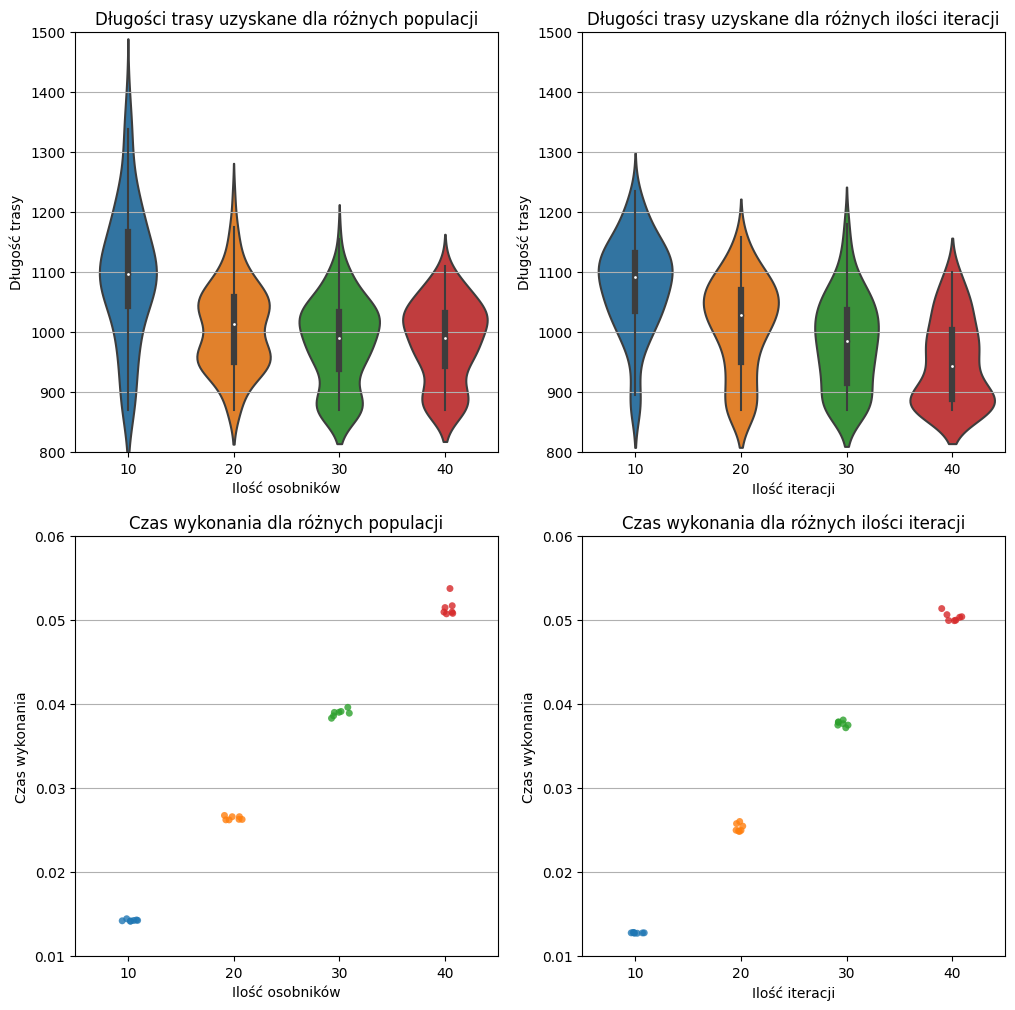

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

sns.violinplot(lossRunsCandRank, ax=ax[0][0])
ax[0][0].grid(axis='y')
ax[0][0].set_ylim([800, 1500])
ax[0][0].set_xlabel('Ilość osobników')
ax[0][0].set_ylabel('Długość trasy')
ax[0][0].set_title('Długości trasy uzyskane dla różnych populacji');

sns.violinplot(lossRunsIterRank, ax=ax[0][1])
ax[0][1].grid(axis='y')
ax[0][1].set_ylim([800, 1500])
ax[0][1].set_xlabel('Ilość iteracji')
ax[0][1].set_ylabel('Długość trasy')
ax[0][1].set_title('Długości trasy uzyskane dla różnych ilości iteracji');

sns.stripplot(timeRunsCandRank, ax=ax[1][0], alpha=0.8)
ax[1][0].grid(axis='y')
ax[1][0].set_ylim([0.01, 0.06])
ax[1][0].set_xlabel('Ilość osobników')
ax[1][0].set_ylabel('Czas wykonania')
ax[1][0].set_title('Czas wykonania dla różnych populacji');

sns.stripplot(timeRunsIterRank, ax=ax[1][1], alpha=0.8)
ax[1][1].grid(axis='y')
ax[1][1].set_ylim([0.01, 0.06])
ax[1][1].set_xlabel('Ilość iteracji')
ax[1][1].set_ylabel('Czas wykonania')
ax[1][1].set_title('Czas wykonania dla różnych ilości iteracji');

fig.savefig('04_timeRank.png')

# Wpływ liczebności populacji i ilości iteracji - metoda ruletkowa

## Liczebność populacji

In [9]:
t10 = Traveler(cityCount=10, size=300, populationCount=10, randomState=42, selection='roulette')
lossRun10cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun10cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=20, randomState=42, selection='roulette')
lossRun20cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun20cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=30, randomState=42, selection='roulette')
lossRun30cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun30cand = %timeit -o t10.fit(25)

t10 = Traveler(cityCount=10, size=300, populationCount=40, randomState=42, selection='roulette')
lossRun40cand = [t10.fit(25).minLoss[-1] for _ in range(100)]
timeRun40cand = %timeit -o t10.fit(25)

lossRunsCandRoulette = pd.DataFrame({"10" : lossRun10cand, "20" : lossRun20cand, "30" : lossRun30cand, "40" : lossRun40cand})
timeRunsCandRoulette = pd.DataFrame({"10" : timeRun10cand.timings, "20" : timeRun20cand.timings,
                                     "30" : timeRun30cand.timings, "40" : timeRun40cand.timings})

14.6 ms ± 92.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.8 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.1 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.6 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Ilość iteracji

In [10]:
t10 = Traveler(cityCount=10, size=300, populationCount=25, randomState=42, selection='roulette')
               
lossRun10iter = [t10.fit(10).minLoss[-1] for _ in range(100)]
timeRun10iter = %timeit -o t10.fit(10)

lossRun20iter = [t10.fit(20).minLoss[-1] for _ in range(100)]
timeRun20iter = %timeit -o t10.fit(20)
               
lossRun30iter = [t10.fit(30).minLoss[-1] for _ in range(100)]
timeRun30iter = %timeit -o t10.fit(30)
               
lossRun40iter = [t10.fit(40).minLoss[-1] for _ in range(100)]
timeRun40iter = %timeit -o t10.fit(40)

lossRunsIterRoulette = pd.DataFrame({"10" : lossRun10iter, "20" : lossRun20iter, "30" : lossRun30iter, "40" : lossRun40iter})
timeRunsIterRoulette = pd.DataFrame({"10" : timeRun10iter.timings, "20" : timeRun20iter.timings,
                                     "30" : timeRun30iter.timings, "40" : timeRun40iter.timings})

13 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.7 ms ± 675 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.2 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.6 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


C:\Users\Radek\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\Users\Radek\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


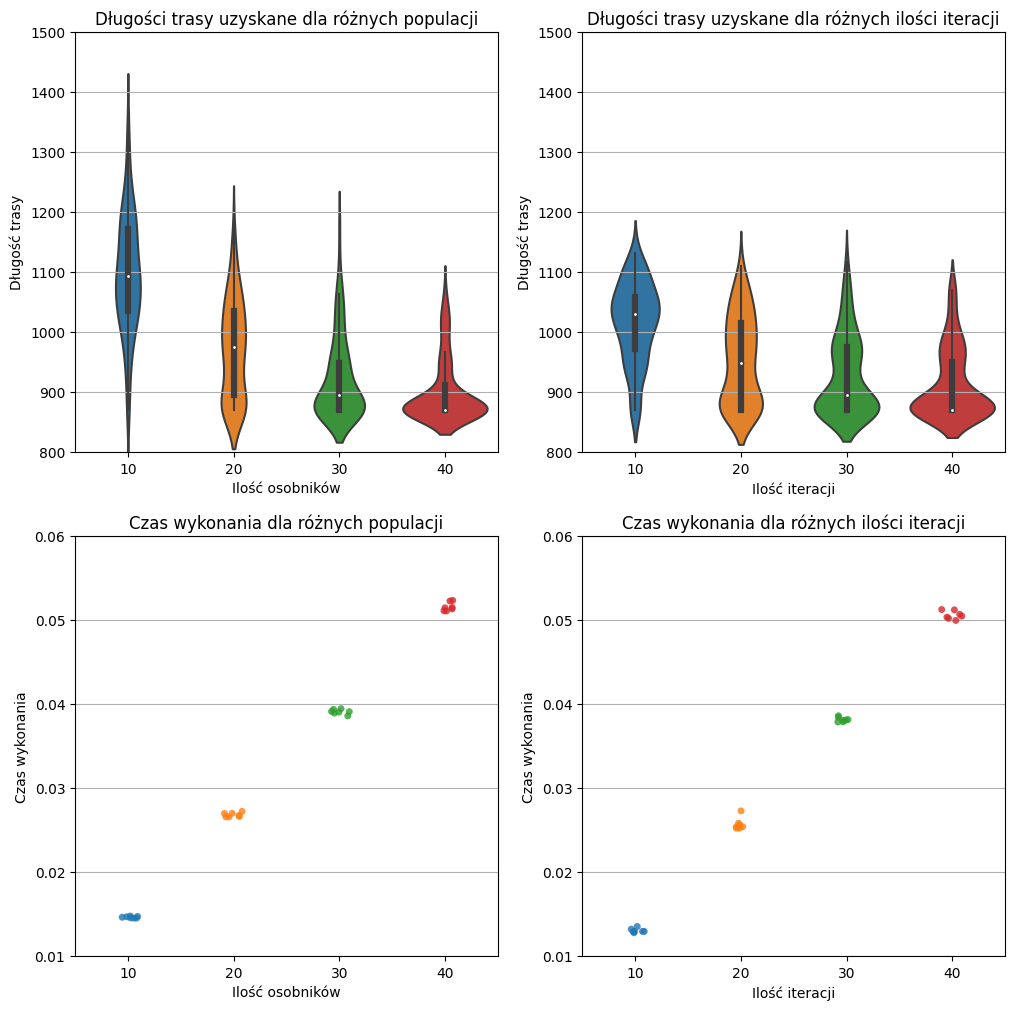

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.violinplot(lossRunsCandRoulette, ax=ax[0][0])
ax[0][0].grid(axis='y')
ax[0][0].set_ylim([800, 1500])
ax[0][0].set_xlabel('Ilość osobników')
ax[0][0].set_ylabel('Długość trasy')
ax[0][0].set_title('Długości trasy uzyskane dla różnych populacji');

sns.violinplot(lossRunsIterRoulette, ax=ax[0][1])
ax[0][1].grid(axis='y')
ax[0][1].set_ylim([800, 1500])
ax[0][1].set_xlabel('Ilość iteracji')
ax[0][1].set_ylabel('Długość trasy')
ax[0][1].set_title('Długości trasy uzyskane dla różnych ilości iteracji');

sns.stripplot(timeRunsCandRoulette, ax=ax[1][0], alpha=0.8)
ax[1][0].grid(axis='y')
ax[1][0].set_ylim([0.01, 0.06])
ax[1][0].set_xlabel('Ilość osobników')
ax[1][0].set_ylabel('Czas wykonania')
ax[1][0].set_title('Czas wykonania dla różnych populacji');

sns.stripplot(timeRunsIterRoulette, ax=ax[1][1], alpha=0.8)
ax[1][1].grid(axis='y')
ax[1][1].set_ylim([0.01, 0.06])
ax[1][1].set_xlabel('Ilość iteracji')
ax[1][1].set_ylabel('Czas wykonania')
ax[1][1].set_title('Czas wykonania dla różnych ilości iteracji');

fig.savefig('05_timeRoulette.png')

# Porównanie metod selekcji

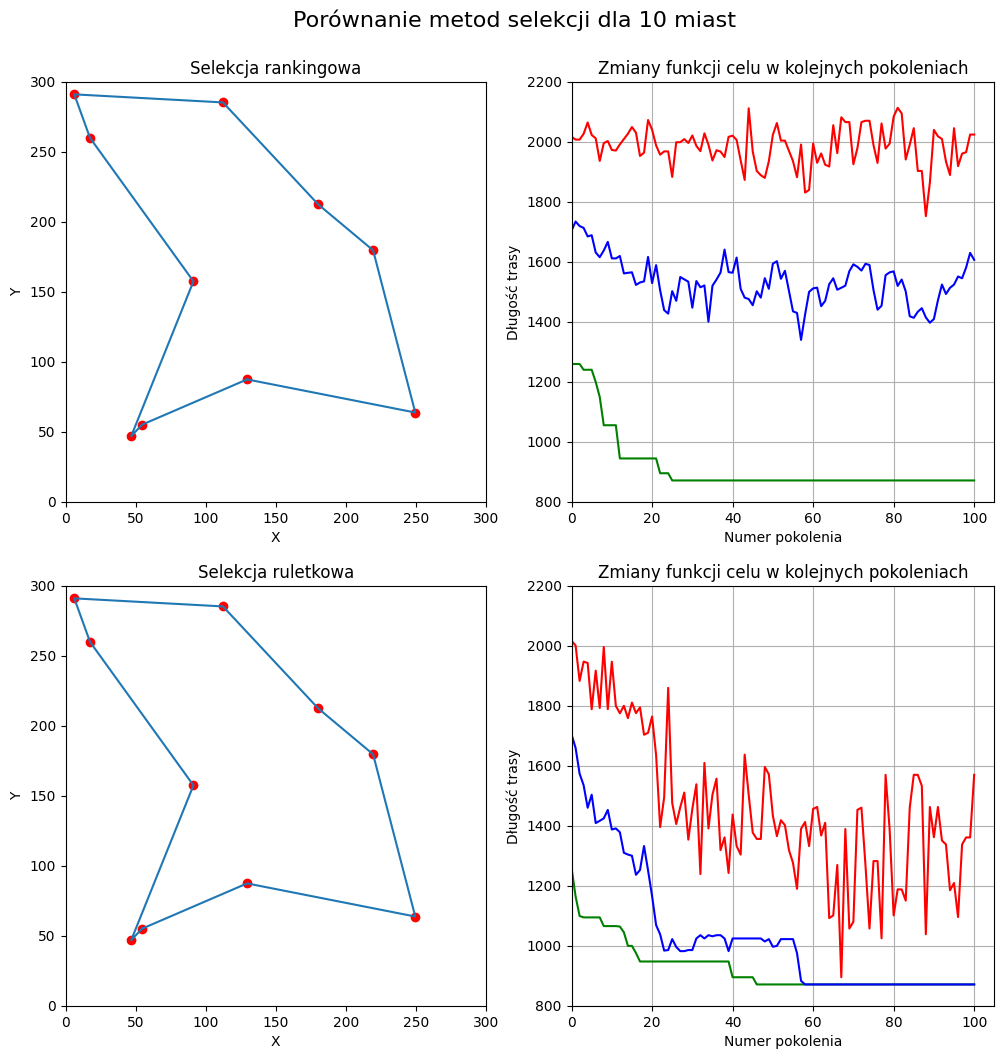

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Porównanie metod selekcji dla 10 miast', fontsize=16, y=0.94)

t10rank = Traveler(cityCount=10, size=300, populationCount=64, randomState=42, selection='rank')
t10rank.fit(100)
t10rank.displaySolution(ax[0][0], title='Selekcja rankingowa')
t10rank.displayLoss(ax[0][1])
ax[0][1].set_ylim([800, 2200])

t10roulette = Traveler(cityCount=10, size=300, populationCount=64, randomState=42, selection='roulette')
t10roulette.fit(100)
t10roulette.displaySolution(ax[1][0], title='Selekcja ruletkowa')
t10roulette.displayLoss(ax[1][1])
ax[1][1].set_ylim([800, 2200])

fig.savefig('06_selectionComp_10.png')

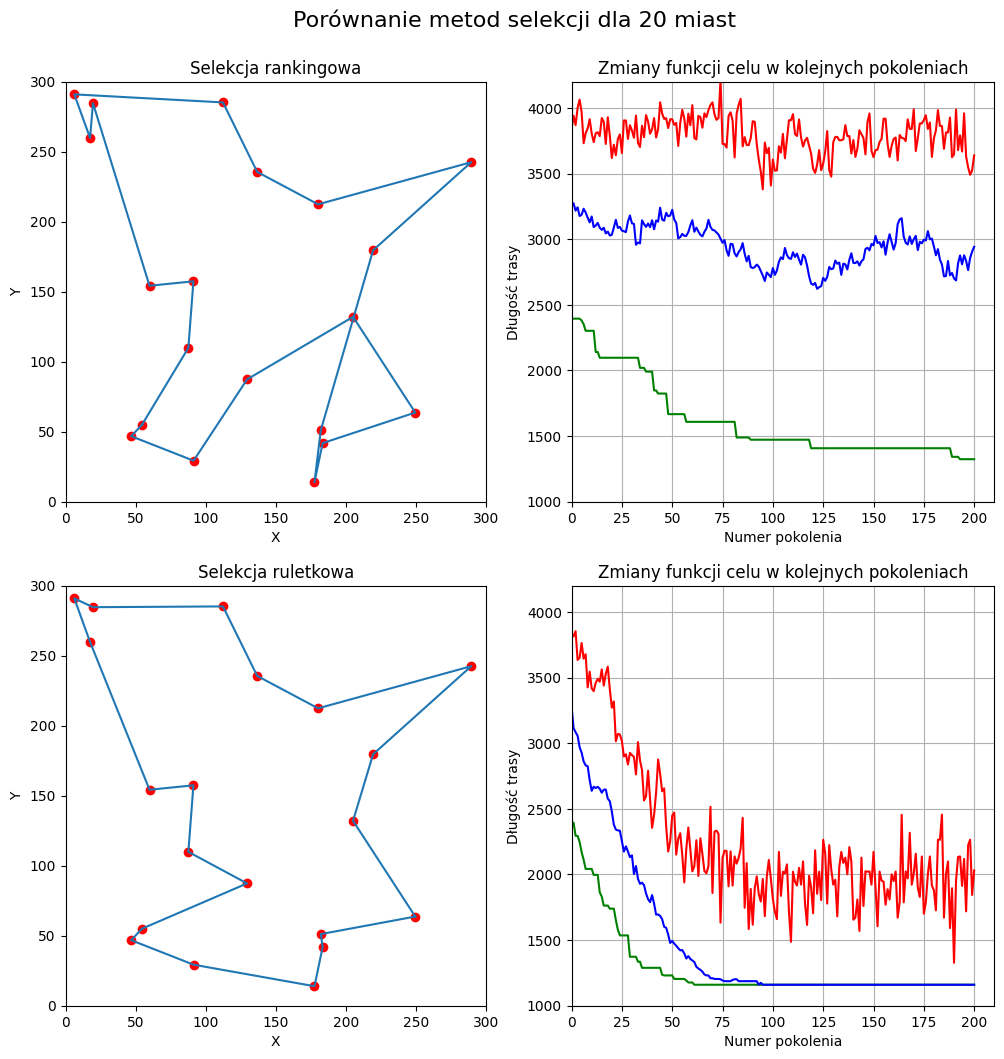

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Porównanie metod selekcji dla 20 miast', fontsize=16, y=0.94)

t20rank = Traveler(cityCount=20, size=300, populationCount=128, randomState=42, selection='rank')
t20rank.fit(200)
t20rank.displaySolution(ax[0][0], title='Selekcja rankingowa')
t20rank.displayLoss(ax[0][1])
ax[0][1].set_ylim([1000, 4200])

t20roulette = Traveler(cityCount=20, size=300, populationCount=128, randomState=42, selection='roulette')
t20roulette.fit(200)
t20roulette.displaySolution(ax[1][0], title='Selekcja ruletkowa')
t20roulette.displayLoss(ax[1][1])
ax[1][1].set_ylim([1000, 4200])

fig.savefig('07_selectionComp_20.png')

In [14]:
parameters = pd.DataFrame({"liczba miast" : [30, 40, 50], 
                           "liczebność populacji" : [1024, 2048, 4096], 
                           "ilość iteracji" : [400, 500, 600]})
parameters.set_index('liczba miast')

,liczebność populacji,ilość iteracji
liczba miast,,
30,1024,400
40,2048,500
50,4096,600


In [15]:
start = time.time()
t30 = Traveler(cityCount=30, size=300, populationCount=1024, randomState=42, selection='roulette', elitismRate=0.02)
t30.fit(400)
t30time = time.time() - start
print("Czas szukania rozwiązania dla 30 miast wyniósł {} min {} sek".format(int(t30time // 60), round(t30time % 60)))

Czas szukania rozwiązania dla 30 miast wyniósł 0 min 54 sek


In [16]:
start = time.time()
t40 = Traveler(cityCount=40, size=300, populationCount=2048, randomState=42, selection='roulette')
t40.fit(500)
t40time = time.time() - start
print("Czas szukania rozwiązania dla 40 miast wyniósł {} min {} sek".format(int(t40time // 60), round(t40time % 60)))

Czas szukania rozwiązania dla 40 miast wyniósł 2 min 53 sek


In [17]:
start = time.time()
t50 = Traveler(cityCount=50, size=300, populationCount=4096, randomState=42, selection='roulette')
t50.fit(600)
t50time = time.time() - start
print("Czas szukania rozwiązania dla 50 miast wyniósł {} min {} sek".format(int(t50time // 60), round(t50time % 60)))

Czas szukania rozwiązania dla 50 miast wyniósł 11 min 8 sek


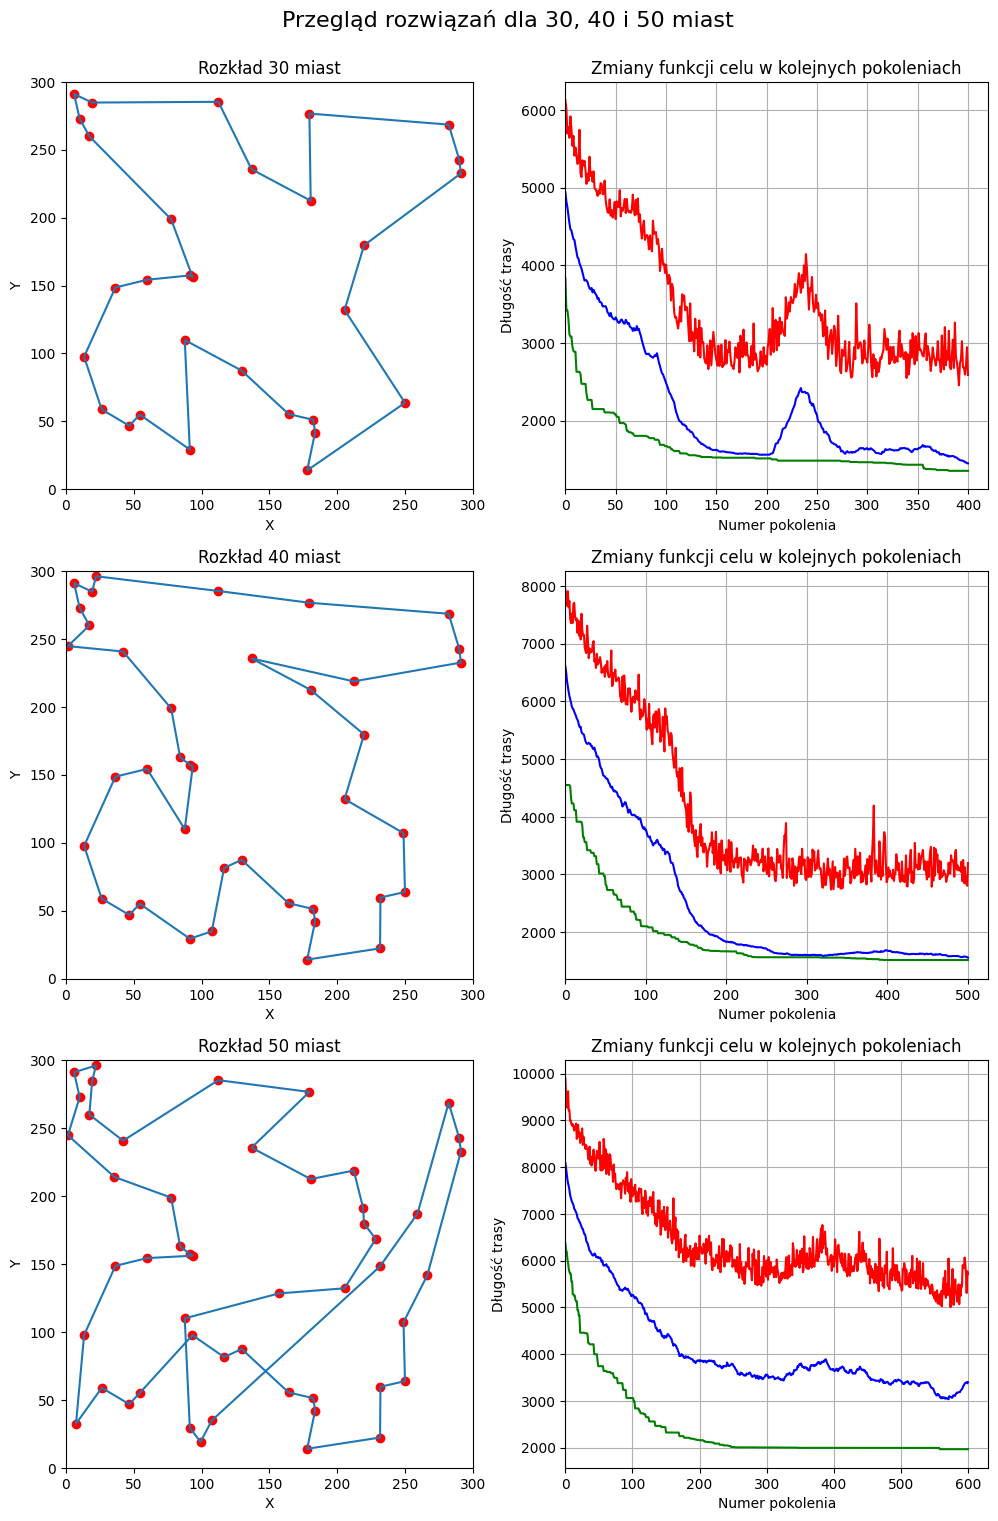

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(12,18))
fig.suptitle('Przegląd rozwiązań dla 30, 40 i 50 miast', fontsize=16, y=0.92)

t30.displaySolution(ax[0][0])
t30.displayLoss(ax[0][1])

t40.displaySolution(ax[1][0])
t40.displayLoss(ax[1][1])

t50.displaySolution(ax[2][0])
t50.displayLoss(ax[2][1])

fig.savefig('08_exampleSolution_30_40_50.png')